<h1 align="center"> Language Classification using Naive Bayes </h1>
<h4 align="center"> ~ Shivam Shukla </h4>


<h6 align="center"> Given a sentence in any of following language, this model will try to predict the language.</h6>

## [Slovak Text](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Text](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Text](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

In [52]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

## Data Exploration and Visualization

In [2]:
def read_file(filename):
    with open(filename,'r') as f:
        data = f.readlines()
    return data

In [3]:
raw_data = dict()

In [4]:
raw_data['sk'] = read_file('Data/Sentences/train_sentences.sk')
raw_data['en'] = read_file('Data/Sentences/train_sentences.en')
raw_data['ch'] = read_file('Data/Sentences/train_sentences.cs')

In [5]:
def show_statistics(data):
    for language, sentences in data.items():
        
        word_list = ' '.join(sentences).split()
        
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = ' '.join(sentences[0].split()[0:8])
        
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [6]:
show_statistics(raw_data)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká je...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little bit....

Language: ch
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi za...



## Zipf's Law 

* Highest frequency word has Rank 1.

* Frequency and Rank are inversely proportional.

* Frequency * Rank shoud be approximately equal to a constant

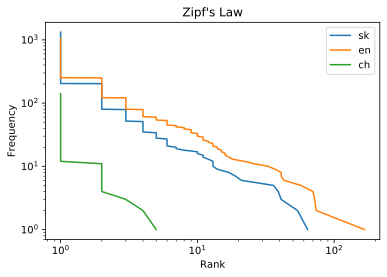

In [7]:
do_law_of_zipf(raw_data)

Here we can see that our dataset doesn't fit properly to Zipf's law as our dataset is very small and Checz language has very less sentences.

## Data Preprocessing

We can use ***Stemming*** and ***Lemmatization*** to preserve the semantics i.e 'The boy plays', 'Boy plays', 'Boy will play' have same meaning.But here it would not be very useful. So we're not gonna use it.

In [8]:
raw_string = 'This 87&$is a sample #&^^string ^(#@which !containg $$many %punctuations and 9342digits8.\n\
It also contains\n. Also Has Hyphens-65% .Please -preprocess -this string.'

raw_string

'This 87&$is a sample #&^^string ^(#@which !containg $$many %punctuations and 9342digits8.\nIt also contains\n. Also Has Hyphens-65% .Please -preprocess -this string.'

In [9]:
pre_processed_string = raw_string.lower().replace('-',' ')
pre_processed_string

'this 87&$is a sample #&^^string ^(#@which !containg $$many %punctuations and 9342digits8.\nit also contains\n. also has hyphens 65% .please  preprocess  this string.'

In [10]:
translation_table  = pre_processed_string.maketrans('\n',' ',string.punctuation+string.digits)
# This creates a translation table which replaces \n with ' '(whitespace), and converts all
# the punctuation and digits to None
translation_table

{10: 32,
 33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None,
 48: None,
 49: None,
 50: None,
 51: None,
 52: None,
 53: None,
 54: None,
 55: None,
 56: None,
 57: None}

Now use this translation table to translate our string.

In [11]:
pre_processed_string = pre_processed_string.translate(translation_table)
pre_processed_string

'this is a sample string which containg many punctuations and digits it also contains  also has hyphens  please  preprocess  this string'

In [12]:
def preprocess_data(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
    
    preprocessed_data = text.lower().replace('-',' ')
    
    translation_table = str.maketrans('\n',' ',string.punctuation+string.digits)
    
    preprocessed_data = preprocessed_data.translate(translation_table)
    
    return preprocessed_data

In [13]:
preprocessed_data = {language: [preprocess_data(sentence) for sentence in sentences] for language,sentences in raw_data.items()}

In [14]:
print("Statistics of Raw Data : \n")
show_statistics(raw_data)
print("\n\n\n\nStatistics of Preprocessed Data : \n")
show_statistics(preprocessed_data)

Statistics of Raw Data : 

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká je...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little bit....

Language: ch
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi za...





Statistics of Preprocessed Data : 

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká je...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2366
Number of unique words	:	 904
Sample extract		:	 i can understand your approach a little

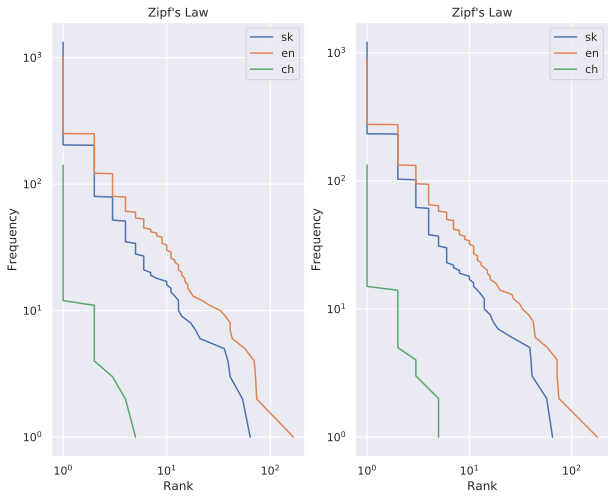

In [67]:
fig,ax  = plt.subplots(1,2,figsize=(10,8))


plt.subplot(1,2,1)
do_law_of_zipf(raw_data)


plt.subplot(1,2,2)
do_law_of_zipf(preprocessed_data)

<h1> Bayes' Theorem</h1>

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Shivam` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Shivam})=\frac{P(\text {my name is Shivam} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Shivam})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Shivam})=\frac{P(\text {my name is Shivam} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Shivam})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Shivam})=\frac{P(\text {my name is Shivam} | \text {en}) \times P(\text {en})}{P(\text {my name is Shivam})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Shivam} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Shivam} | \text {en})
\end{equation}

**Here a problem can occur that if our training set doesn't have the word 'Shivam', then whole term 𝑃(my name is Shivam|en) will be 0, even if 'my' , 'name' etc have 99% probability of being a english word.
So to deal with this problem we can apply SMOOTHING to our model. For this we have 'Alpha' hyperparameter in NaiveBayes Classifier.**


## Vectorizing Training Data



|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Shivam 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Shivam  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

---


In [15]:
training_sentences, y_train = [], []

for k, v in preprocessed_data.items():
    for sentence in v:
        training_sentences.append(sentence)
        y_train.append(k)

In [16]:
vectorizer = CountVectorizer()

In [17]:
X_train = vectorizer.fit_transform(training_sentences)

In [18]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [19]:
nbc = MultinomialNB()

In [20]:
nbc.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
## Here alpha is 1 by default

In [22]:
data_val = dict()
data_val['sk'] = read_file('Data/Sentences/val_sentences.sk')
data_val['ch'] = read_file('Data/Sentences/val_sentences.cs')
data_val['en'] = read_file('Data/Sentences/val_sentences.en')

data_val_preprocessed = {k: [preprocess_data(sentence) for sentence in v] for k, v in data_val.items()}

In [23]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [24]:
X_val = vectorizer.transform(sentences_val)

In [25]:
predictions = nbc.predict(X_val)

In [33]:
nbc.classes_ # ch-0, en-1, sk-2

array(['ch', 'en', 'sk'], dtype='<U2')

In [27]:
from sklearn.metrics import confusion_matrix,classification_report


In [44]:
print(confusion_matrix(y_val,predictions))

[[ 534  389 4077]
 [   0 5000    0]
 [   0  114 4886]]


In [43]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

          ch       1.00      0.11      0.19      5000
          en       0.91      1.00      0.95      5000
          sk       0.55      0.98      0.70      5000

    accuracy                           0.69     15000
   macro avg       0.82      0.69      0.61     15000
weighted avg       0.82      0.69      0.61     15000



In [30]:
cf_matrix = confusion_matrix(y_val,predictions)

In [31]:
import seaborn as sns
sns.set()

Text(66.5, 0.5, 'Predicted Label')

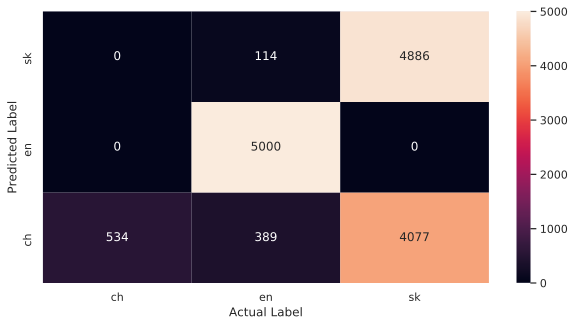

In [47]:
plt.figure(figsize=(10,5))
sns.heatmap(cf_matrix,annot=True,fmt="d",xticklabels=['ch','en','sk'],yticklabels=['ch','en','sk'])
plt.ylim([0,3])
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')